In [1]:
import numpy as np
import numpy.linalg as linalg
import sys

from math import sqrt
import python_inventory as pyinv

In [2]:
def dist2(x):
    return (x @ x)

def mdist2(x, S1):
    return (S1 @ x) @ x

class KMeansMahalanobis:
    #
    def __init__(self, q, tol=1.0e-9, n_iter=500):
        self.q = q
        self.n_iter = n_iter
        self.tol = tol
    #
    def dist(self, x):
        S1 = self.S1
        c = self.c
        ds = [mdist2(x - c[j], S1[j]) for j in range(self.q)]
        d_min = min(ds)
        return sqrt(d_min)
    #
    def find_clusters(self, X):
        q = self.q
        I = [[] for j in range(q)]
        S1 = self.S1
        c = self.c
        for k, xk in enumerate(X):
            ds = [mdist2(xk - c[j], S1[j]) for j in range(q)]
            d_min = min(ds)
            for j in range(q):
                if ds[j] == d_min:
                    I[j].append(k)
        return I
    #
    def find_centers(self, X, I):
        n = X.shape[1]
        c = np.zeros((self.q, n), 'd')
        for j in range(self.q):
            Ij = I[j]
            cj = sum((X[k] for k in Ij), start=np.zeros(n, 'd'))
            cj /= len(Ij)
            c[j,:] = cj
        return c
    #
    def initial_centers(self, X):
        N, n = X.shape
        q = self.q
        
        xmin = np.fromiter((min(X[:,i]) for i in range(n)), 'd', n)
        xmax = np.fromiter((max(X[:,i]) for i in range(n)), 'd', n)
        c = np.random.random(size=(q, n))
        return xmin + c * (xmax - xmin)
    #
    def find_covs(self, X, I):
        n = X.shape[1]
        S1 = []
        n1 = 1.0/n
        for j in range(self.q):
            Sj = np.zeros((n,n), 'd')
            Ij = I[j]
            cj = self.c[j]
            for k in Ij:
                v = X[k] - cj
                Sj += np.outer(v, v)
            Sj /= len(Ij)
            Sj = linalg.inv(Sj)
            Sj /= linalg.det(Sj) ** n1
            S1.append(Sj)
        return S1
    #
    def stop_condition(self, c, c_prev):
        d_max = max(dist2(c[j]-c_prev[j]) for j in range(self.q))
        d_max = sqrt(d_max)
        print(d_max)
        if d_max < self.tol:
            return True
        
        return False
    #
    def fit(self, X):
        q = self.q
        n = X.shape[1]
        self.c = self.initial_centers(X)
        self.S1 = [np.identity(n) for j in range(q)]
        for K in range(self.n_iter):
            c_prev = self.c.copy()
            self.I = I = self.find_clusters(X)
            self.c = self.find_centers(X, I)
            self.S1 = self.find_covs(X, I)
            if self.stop_condition(self.c, c_prev):
                break
        self.K = K + 1

In [3]:
import sklearn.datasets as datasets
import matplotlib.pyplot as plt

In [4]:
X_iris, Y_iris = datasets.load_iris(return_X_y=True)

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=2)
pca.fit(X_iris)
X = pca.transform(X_iris)
Y = Y_iris

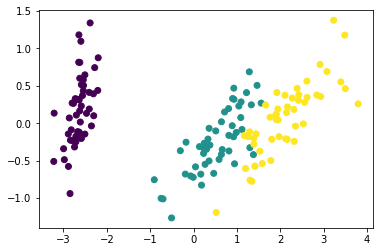

In [7]:
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [8]:
XX, YY = np.meshgrid(np.linspace(-4,4,100), np.linspace(-4,4,100))
XY = np.c_[(XX.ravel(), YY.ravel())]

In [9]:
kmm = KMeansMahalanobis(3)

In [10]:
kmm.fit(X)

0.9533478965956452
0.46519351411056425
0.2905865613145329
0.2637402085640746
0.22412031944734387
0.14039970348369327
0.07727716477509658
0.1523733427723709
0.09772771325903834
0.07027210406545832
0.017681252711020324
0.0


In [11]:
print(kmm.K)
print(kmm.c)

12
[[ 2.09922312  0.02961565]
 [-2.64241546  0.19088505]
 [ 0.54319234 -0.2205007 ]]


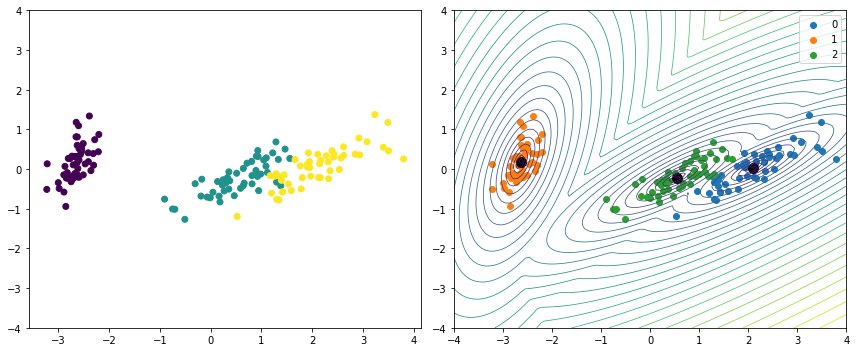

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.ylim(-4,4)
plt.subplot(1,2,2)
for j, Ij in enumerate(kmm.I):
    Xj = X[Ij]
    plt.scatter(Xj[:,0], Xj[:,1], label=str(j))
plt.scatter(kmm.c[:,0], kmm.c[:,1], c='k', s=100)

Z = np.fromiter((sqrt(kmm.dist(xy)) for xy in XY), 'd', len(XY))
ZZ = Z.reshape(XX.shape)
plt.contour(ZZ, levels=np.linspace(Z.min(), Z.max(), 30), extent=(-4,4,-4,4), linewidths=0.75)

plt.legend()
plt.tight_layout()
plt.show()

In [13]:
class RKMeansMahalanobis:
    #
    def __init__(self, q, avrfunc=None, tol=1.0e-9, n_iter=500):
        self.q = q
        self.n_iter = n_iter
        self.tol = tol
        if avrfunc is None:
            self.avrfunc = pyinv.ArithMean()
        else:
            self.avrfunc = avrfunc
    #
    def dist2(self, x):
        S1 = self.S1
        c = self.c
        return min((mdist2(x - c[j], S1[j]) for j in range(self.q)))
    #
    def find_clusters(self, X):
        q = self.q
        I = [[] for j in range(q)]
        S1 = self.S1
        c = self.c
        for k, xk in enumerate(X):
            ds = [mdist2(xk - c[j], S1[j]) for j in range(q)]
            d_min = min(ds)
            for j in range(q):
                if ds[j] == d_min:
                    I[j].append(k)
        return I
    #
    def find_centers(self, X, I, G):
        n = X.shape[1]
        c = np.zeros((self.q, n), 'd')
        for j in range(self.q):
            Ij = I[j]
            cj = sum((G[k] * X[k] for k in Ij), start=np.zeros(n, 'd'))
            GG = sum(G[k] for k in Ij)
            c[j,:] = cj / GG
        return c
    #
    def initial_centers(self, X):
        N, n = X.shape
        q = self.q
        
        xmin = np.fromiter((min(X[:,i]) for i in range(n)), 'd', n)
        xmax = np.fromiter((max(X[:,i]) for i in range(n)), 'd', n)
        c = np.random.random(size=(q, n))
        return xmin + c * (xmax - xmin)
    #
    def find_covs(self, X, I, G):
        n = X.shape[1]
        S1 = []
        n1 = 1.0/n
        for j in range(self.q):
            Sj = np.zeros((n,n), 'd')
            Ij = I[j]
            cj = self.c[j]
            g = 0
            for k in Ij:
                v = X[k] - cj
                Sj += G[k] * np.outer(v, v)
                g += G[k]
            Sj /= g
            Sj = linalg.pinv(Sj)
            Sj /= linalg.det(Sj) ** n1
            S1.append(Sj)
        return S1
    #
    def stop_condition(self, c, c_prev):
        d_max = max(dist2(c[j]-c_prev[j]) for j in range(self.q))
        d_max = sqrt(d_max)
        print(d_max)
        if d_max < self.tol:
            return True
        
        return False
    #
    def fit(self, X):
        q = self.q
        n = X.shape[1]
        N = X.shape[0]
        self.c = self.initial_centers(X)
        self.S1 = [np.identity(n) for j in range(q)]
        for K in range(self.n_iter):
            c_prev = self.c.copy()
            self.ds = np.fromiter((self.dist2(x) for x in X), 'd', N)
            dd = self.avrfunc.evaluate(self.ds)
            G = self.avrfunc.gradient(self.ds)
            self.I = self.find_clusters(X)
            self.c = self.find_centers(X, self.I, G)
            self.S1 = self.find_covs(X, self.I, G)
            if self.stop_condition(self.c, c_prev):
                break
        self.K = K + 1

In [26]:
rhofunc = pyinv.SoftQuantileFunc(pyinv.SoftAbs(0.001), 0.96)
avrfunc = pyinv.WMMean(rhofunc)
kmm_rob = RKMeansMahalanobis(3, avrfunc, tol=1.0e-6)

In [27]:
kmm_rob.fit(X)

0.9412408455097555
0.1844207394018575
0.0351157655783373
8.79271056843877e-05
6.156570726818841e-06
3.416609563723478e-07


In [28]:
print(kmm_rob.K)
print(kmm_rob.c)
print(kmm_rob.S1)

6
[[-2.64248765e+00  1.90878160e-01]
 [ 5.20448189e-01 -2.22422585e-01]
 [ 1.99852343e+00 -1.84539401e-03]]
[array([[ 2.5071303 , -0.64546945],
       [-0.64546945,  0.56504076]]), array([[ 1.51536981, -1.63593495],
       [-1.63593495,  2.42599735]]), array([[ 1.11397427, -1.38094953],
       [-1.38094953,  2.60959492]])]


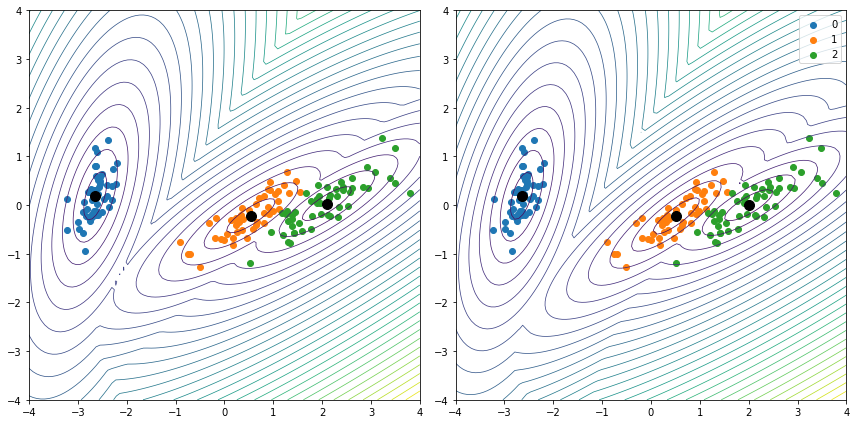

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for j, Ij in enumerate(kmm.I):
    Xj = X[Ij]
    plt.scatter(Xj[:,0], Xj[:,1], label=str(j))
plt.scatter(kmm.c[:,0], kmm.c[:,1], c='k', s=100)

Z = np.fromiter((kmm.dist(xy) for xy in XY), 'd', len(XY))
ZZ = Z.reshape(XX.shape)
plt.contour(ZZ, levels=np.linspace(Z.min(), Z.max(), 30), extent=(-4,4,-4,4), linewidths=0.75)

plt.subplot(1,2,2)
for j, Ij in enumerate(kmm_rob.I):
    Xj = X[Ij]
    plt.scatter(Xj[:,0], Xj[:,1], label=str(j))
plt.scatter(kmm_rob.c[:,0], kmm_rob.c[:,1], c='k', s=100)

Z = np.fromiter((sqrt(kmm_rob.dist2(xy)) for xy in XY), 'd', len(XY))
ZZ = Z.reshape(XX.shape)
plt.contour(ZZ, levels=np.linspace(Z.min(), Z.max(), 30), extent=(-4,4,-4,4), linewidths=0.75)

plt.legend()
plt.tight_layout()
plt.show()

In [18]:
S = np.array([[1,0,0],[1,2,1],[0,0,1]], 'd')
# print(S)
#print(linalg.det(S))
x = np.array([1,2,3], 'd')
# print(np.dot(x, S))
# print(np.dot(S, x))
np.dot(np.dot(S, x), x)

26.0

In [19]:
np.outer(x, x)

array([[1., 2., 3.],
       [2., 4., 6.],
       [3., 6., 9.]])

In [20]:
mdist2(x, S)

26.0

In [21]:
print(0, kmm.I[0])
print(1, kmm.I[1])
print(2, kmm.I[2])

0 [68, 72, 83, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
2 [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 110, 127, 138]
